In [2]:
#bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
#import holidays
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
#importar dados
df = pd.read_excel("estatisticas\\dados_originais_atlas.xlsx")
df["data"] = "1/" + df.mes.astype("str") + "/" + df.ano.astype("str")
df["data"] = pd.to_datetime(df.data, format="%d/%m/%Y", dayfirst=True)
df["periodo"] = df.data.dt.to_period("M")
df = df[["periodo", "codigo", "venda"]].groupby(["periodo", "codigo"]).sum().reset_index()
df["vendas"] = [i * -1 if i < 0 else i for i in df.venda]

In [4]:
df.sort_values(by="venda").head()

,periodo,codigo,venda,vendas
11217,2024-12,400000693,-126.0,126.0
10,2018-01,1490001,-116.0,116.0
12303,2025-04,400000460,-58.0,58.0
4057,2021-04,300000272,-32.0,32.0
13179,2025-07,300001717,-23.0,23.0


<positron-console-cell-5>:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.


<Axes: title={'center': 'Total de vendas por mês'}, xlabel='periodo'>

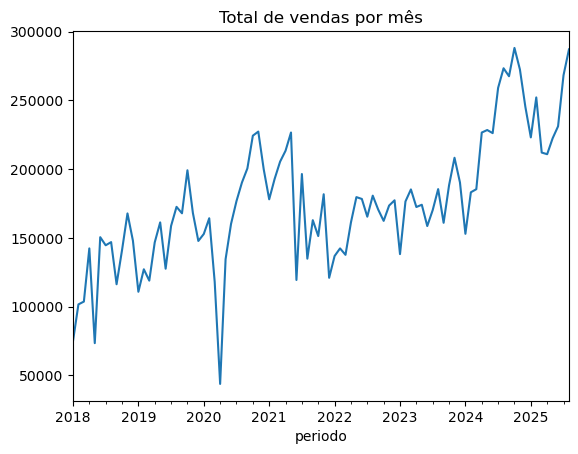

In [5]:
# Observar a continuidade dos dados
df.set_index("periodo").resample("M")["vendas"].sum().plot(title="Total de vendas por mês")

## Criar cluster

C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

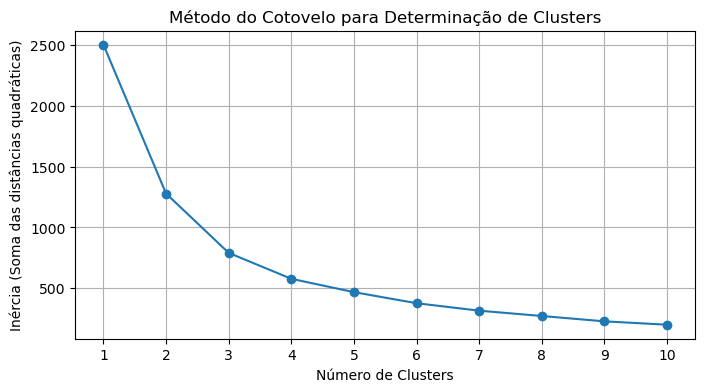

In [6]:
# Criar features agregadas para cada produto
product_features = df.groupby('codigo').agg({
    'vendas': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [7]:
# Clusterização final
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(product_features_scaled)

# Mapear os clusters de volta para o DataFrame original
df['cluster'] = df['codigo'].map(dict(zip(product_features.index, clusters)))

C:\Users\marce\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


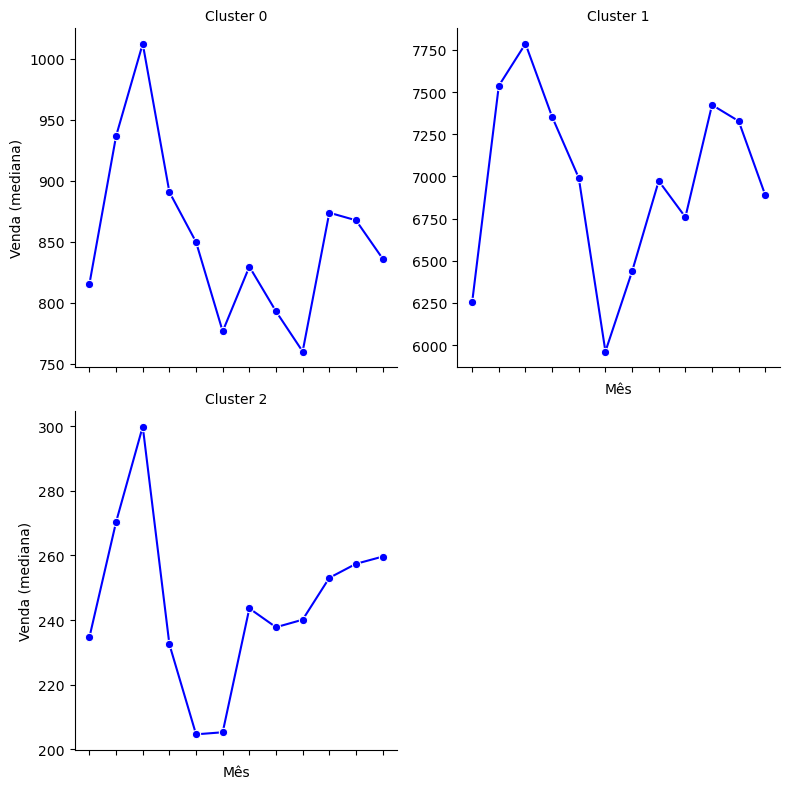

In [9]:
# Agrupar por semana e cluster, calculando a mediana das vendas
df["mes"] = df["periodo"].dt.month.astype("str") 
df_cluster = df.groupby(["mes", "cluster"])["vendas"].mean().reset_index()

# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df_cluster, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='mes', y='vendas', marker='o', color='b')  # Adicionando cor fixa para consistência
g.set_titles("Cluster {col_name}")
g.set_xticklabels(rotation=45)  # Rotacionar rótulos do eixo x
g.set_axis_labels("Mês", "Venda (mediana)")  # Nomes dos eixos
g.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

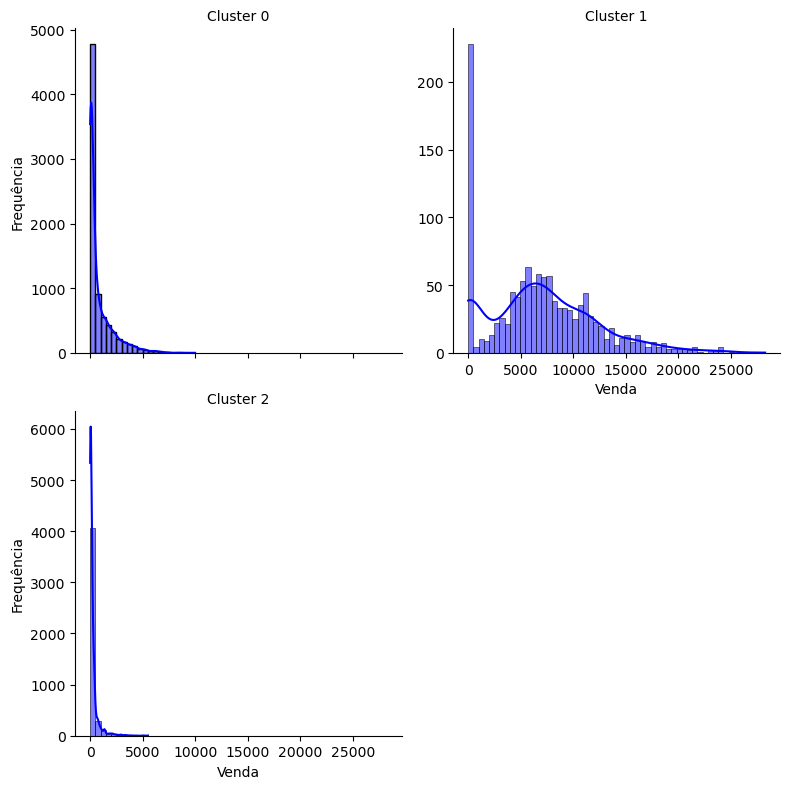

In [10]:
# FacetGrid: um gráfico por cluster
g = sns.FacetGrid(df, col='cluster', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.histplot, x='vendas', binwidth=500, color="b", kde=True)  # Adicionando cor fixa para consistência bins=30
g.set_titles("Cluster {col_name}")
g.set_axis_labels("Venda", "Frequência")  # Nomes dos eixos
g.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

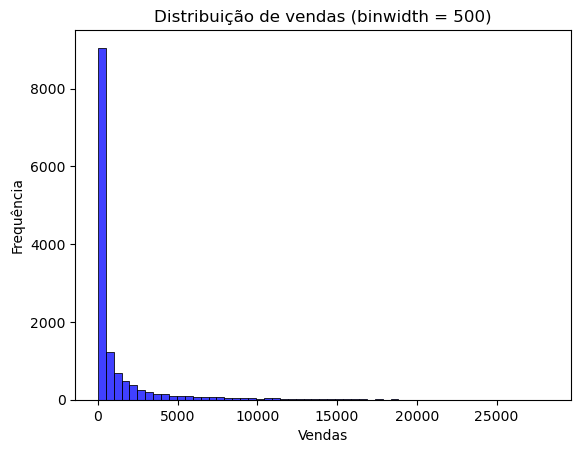

In [34]:
#Ver quantos produtos têm histórico curto
sns.histplot(data=df, x='vendas', binwidth=500, color='b')
plt.title("Distribuição de vendas (binwidth = 500)")
plt.xlabel("Vendas")
plt.ylabel("Frequência")
plt.show()

In [17]:
# ANOVA para testar a diferença de média entre mes
#df_acumulado = df.groupby("periodo").agg(
#    venda = ("vendas", "sum")
#).reset_index()

#df_acumulado["mes"] = df_acumulado.periodo.dt.month

# Criar listas separadas por mes
grupo_1 = df[df['mes'] == "1"]['venda']
grupo_2 = df[df['mes'] == "2"]['venda']
grupo_3 = df[df['mes'] == "3"]['venda']
grupo_4 = df[df['mes'] == "4"]['venda']
grupo_5 = df[df['mes'] == "5"]['venda']
grupo_6 = df[df['mes'] == "6"]['venda']
grupo_7 = df[df['mes'] == "7"]['venda']
grupo_8 = df[df['mes'] == "8"]['venda']
grupo_9 = df[df['mes'] == "9"]['venda']
grupo_10 = df[df['mes'] == "10"]['venda']
grupo_11 = df[df['mes'] == "11"]['venda']
grupo_12 = df[df['mes'] == "12"]['venda']

# Como estamos comparando média entre mais de dois grupos (P, M, G). Teste mais adequado é ANOVA (análise de variância).
f_stat, p_val = f_oneway(grupo_1, grupo_2, grupo_3,
                         grupo_4, grupo_5, grupo_6, grupo_7,
                         grupo_8, grupo_9, grupo_10, grupo_11,
                         grupo_12)

# Se p_val < 0.05, existe diferença estatística entre pelo menos dois grupos.
print(f'Estatística F: {f_stat}')
print(f'p-valor{p_val}')

Estatística F: 1.8436196917730647
p-valor0.0417542712300979


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Se a ANOVA der p < 0.05, você deve rodar um Tukey HSD para saber quais pares de tamanhos são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df['venda'], groups=df['mes'], alpha=0.05)

print(tukey_result.summary())

C:\Users\marce\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     1     10  160.2338 0.9699 -223.3506 543.8182  False
     1     11  201.1239 0.8617  -182.174 584.4217  False
     1     12     7.582    1.0  -374.028 389.1919  False
     1      2  -66.9222    1.0 -435.3494  301.505  False
     1      3 -172.1886 0.9291 -537.3325 192.9553  False
     1      4  -96.9082 0.9994 -464.5621 270.7457  False
     1      5  -83.6329 0.9998 -447.2836 280.0179  False
     1      6  -113.895 0.9972 -478.1889 250.3988  False
     1      7    4.7484    1.0 -357.3958 366.8926  False
     1      8   -16.301    1.0  -375.522   342.92  False
     1      9   -8.4529    1.0 -387.5397 370.6339  False
    10     11   40.8901    1.0  -340.043 421.8232  False
    10     12 -152.6518 0.9773 -531.8865 226.5829  False
    10      2  -227.156 0.6736 -593.1224 138.8104  False
    10      3 -332.4224 0.1096 

In [108]:
df.groupby("periodo")["venda"].sum().sort_index()

periodo
2018-01     74441.0
2018-02    101527.0
2018-03    103592.0
2018-04    142266.0
2018-05     73345.0
             ...   
2025-04    210655.0
2025-05    222330.0
2025-06    231070.0
2025-07    268202.0
2025-08    287030.0
Freq: M, Name: venda, Length: 92, dtype: float64

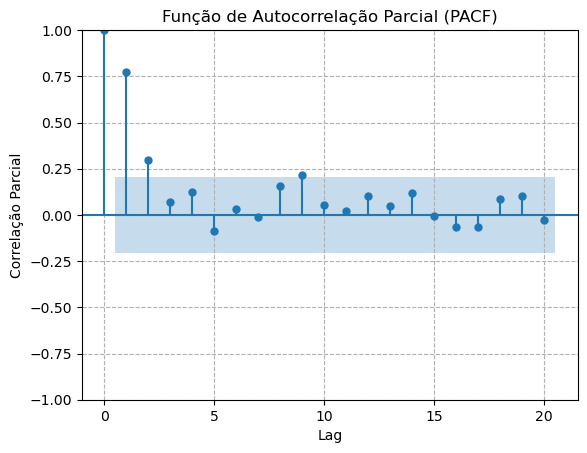

In [38]:
# Agrupar por data e somar vendas (caso haja múltiplos produtos)
ts_vendas = df.groupby("periodo")["vendas"].sum().sort_index()

# Plotar PACF (substitua ts_vendas por ts_produto se necessário)
plot_pacf(ts_vendas, lags=20, alpha=0.05, method='ols')  # alpha=0.05 → 95% confiança
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlação Parcial')
plt.grid(linestyle='--')
plt.show()

In [114]:
#produtos mais vendidos
df.groupby("codigo")["venda"].sum().sort_values(ascending=False).head()

codigo
300000708    792703.0
1520002      752127.0
300000713    612551.0
300000711    574800.0
300000714    531167.0
Name: venda, dtype: float64

In [56]:
ts_produto.to_excel("correlacao_produto.xlsx")

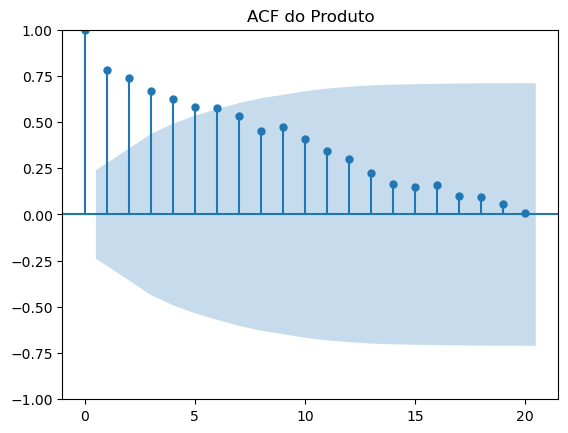

In [39]:
# Calcular ACF para um produto específico (ex.: primeiro da lista)
#produto_exemplo = produtos_validos[0]
ts_produto = df[df.codigo == 300000708].set_index('periodo')['venda'].sort_index()

plot_acf(ts_produto, lags=min(20, len(ts_produto)-1), alpha=0.05)
plt.title(f'ACF do Produto')
plt.show()

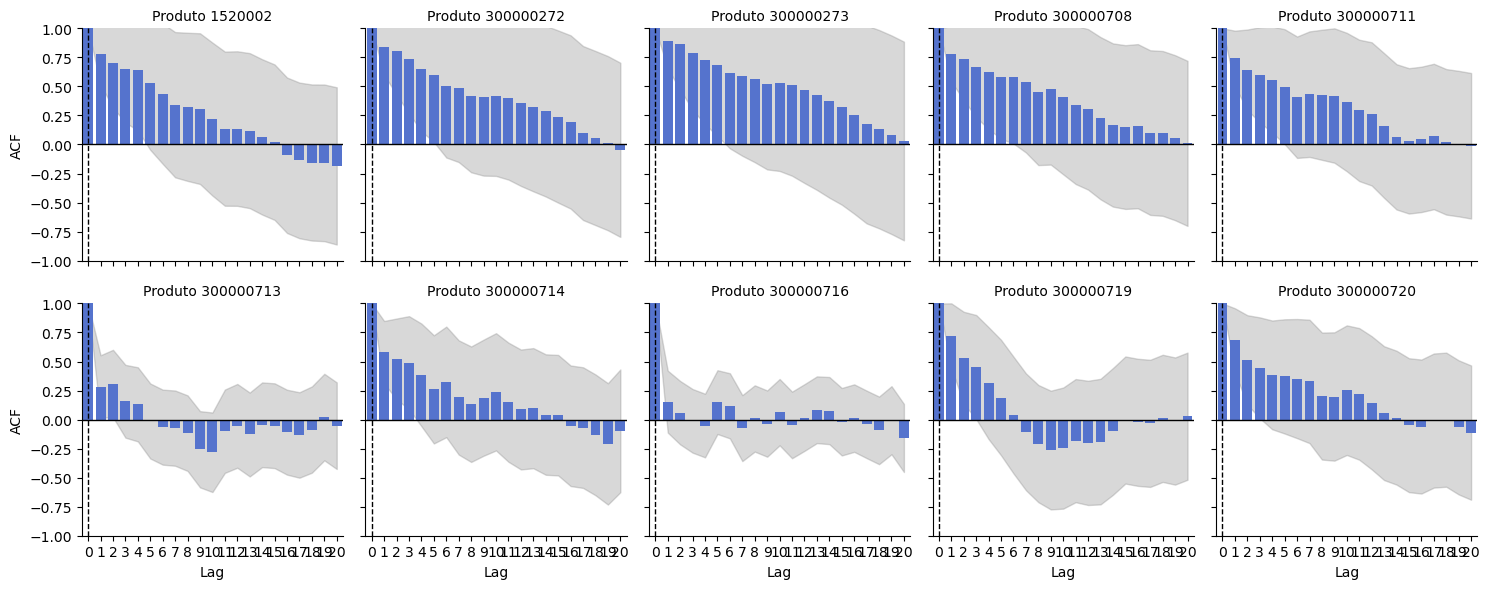

In [50]:
# --- 1. Selecionar os 10 produtos mais vendidos ---
top10 = (
    df.groupby('codigo')['venda']
    .sum()
    .nlargest(10)
    .index
)

# --- 2. Calcular ACF e intervalos com parâmetros idênticos ao plot_acf ---
acf_list = []

for codigo in top10:
    ts = (
        df[df['codigo'] == codigo]
        .set_index('periodo')['venda']
        .sort_index()
    )
    
    # Mesmo cálculo que plot_acf (fft=True, adjusted=False)
    acf_vals, confint = acf(
        ts, 
        nlags=min(20, len(ts)-1), 
        fft=True, 
        adjusted=False, 
        alpha=0.05
    )
    
    acf_df = pd.DataFrame({
        'lag': range(len(acf_vals)),
        'acf': acf_vals,
        'lower': confint[:, 0],
        'upper': confint[:, 1],
        'codigo': codigo
    })
    acf_list.append(acf_df)

acf_df_all = pd.concat(acf_list, ignore_index=True)

# --- 3. Função auxiliar para plotar ACF + intervalo de confiança ---
def plot_acf_with_ci(data, color, **kwargs):
    # Área do intervalo de confiança (cinza)
    plt.fill_between(
        data['lag'], data['lower'], data['upper'],
        color='gray', alpha=0.3
    )
    # Barras da ACF
    sns.barplot(x='lag', y='acf', data=data, color=color, **kwargs)
    # Linhas de referência
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1, linestyle='--')
    plt.ylim(-1, 1)

# --- 4. FacetGrid com parâmetros fixos ---
g = sns.FacetGrid(acf_df_all, col='codigo', col_wrap=5, height=3, sharey=True)
g.map_dataframe(plot_acf_with_ci, color='royalblue')

# --- 5. Ajustes visuais ---
g.set_titles("Produto {col_name}")
g.set_axis_labels("Lag", "ACF")
g.tight_layout()
plt.show()

In [51]:
# --- 1. Selecionar os 10 produtos mais vendidos ---
top10 = (
    df.groupby('codigo')['vendas']
    .sum()
    .nlargest(10)
    .index
)

# --- 2. Calcular métricas da ACF para cada produto ---
resumo = []

for codigo in top10:
    ts = (
        df[df['codigo'] == codigo]
        .set_index('periodo')['vendas']
        .sort_index()
    )
    
    # Mesmo cálculo que o plot_acf() (fft=True, adjusted=False)
    acf_vals, confint = acf(
        ts, 
        nlags=min(20, len(ts)-1), 
        fft=True, 
        adjusted=False, 
        alpha=0.05
    )
    
    # Determinar quais lags são significativos (fora do intervalo)
    significativos = np.where((acf_vals < confint[:, 0]) | (acf_vals > confint[:, 1]))[0]
    n_significativos = len(significativos)
    
    # ACF nos dois primeiros lags (quando possível)
    acf1 = acf_vals[1] if len(acf_vals) > 1 else np.nan
    acf2 = acf_vals[2] if len(acf_vals) > 2 else np.nan
    
    # Interpretação automática
    if n_significativos == 0:
        padrao = "ruidoso / sem dependência temporal"
    elif acf1 > 0.6:
        padrao = "forte dependência (persistente)"
    elif acf1 < -0.3:
        padrao = "alternância / comportamento cíclico"
    elif n_significativos > 4:
        padrao = "possível sazonalidade"
    else:
        padrao = "dependência moderada"
    
    resumo.append({
        'codigo': codigo,
        'ACF(1)': round(acf1, 3),
        'ACF(2)': round(acf2, 3),
        'lags_significativos': n_significativos,
        'padrao_temporal': padrao
    })

resumo_df = pd.DataFrame(resumo)

# --- 3. Mostrar tabela ordenada pelo ACF(1) ---
resumo_df = resumo_df.sort_values(by='ACF(1)', ascending=False).reset_index(drop=True)

In [135]:
pd.to_datetime(df["periodo"].astype("str"), format="%Y-%m")

0       2018-01-01
1       2018-01-01
2       2018-01-01
3       2018-01-01
4       2018-01-01
           ...    
13630   2025-08-01
13631   2025-08-01
13632   2025-08-01
13633   2025-08-01
13634   2025-08-01
Name: periodo, Length: 13635, dtype: datetime64[ns]

In [52]:
df.head()

,periodo,codigo,venda,vendas,cluster,mes
0,2018-01,1311001,381.0,381.0,0,1
1,2018-01,1312001,1039.0,1039.0,0,1
2,2018-01,1313001,1231.0,1231.0,0,1
3,2018-01,1321001,125.0,125.0,2,1
4,2018-01,1322001,328.0,328.0,0,1


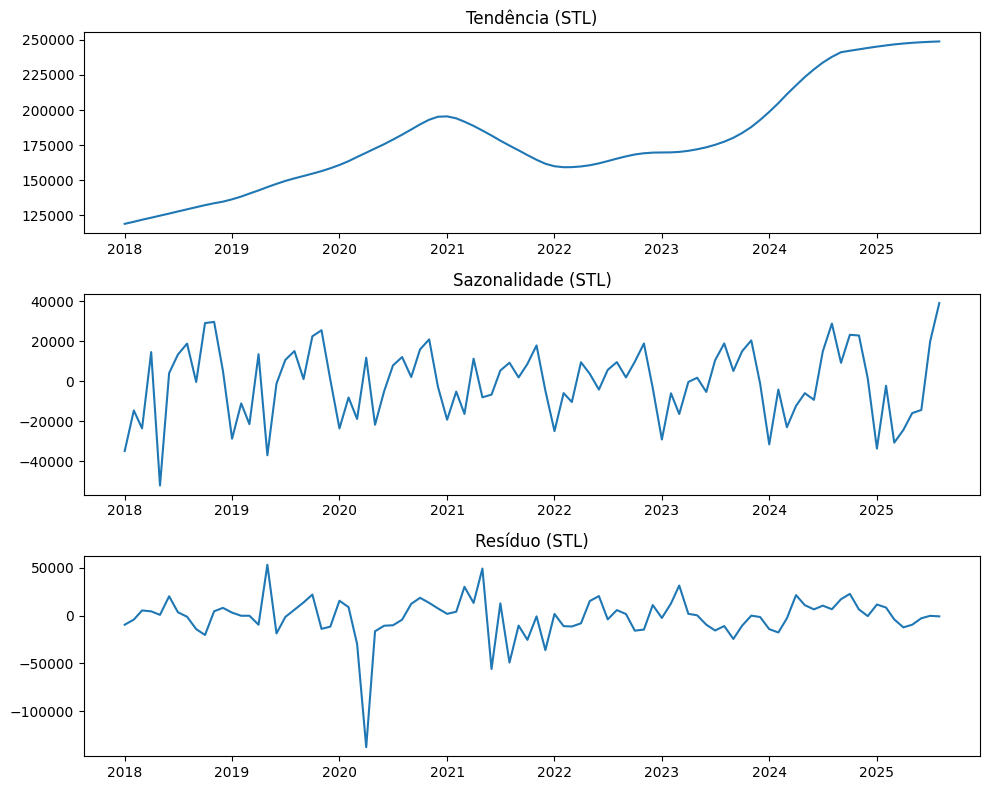

In [136]:
# criando a data completa
df["data"] = pd.to_datetime(df["periodo"].astype("str"), format="%Y-%m")

df_m = (
    df.dropna(subset=["data"])
      .set_index("data")
      .sort_index()
      .resample("MS")
      .agg({"venda":"sum"})
)

# Série de venda
ts = df_m["venda"].fillna(0)

# STL
stl = STL(ts, period=12, robust=True).fit()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(311); ax1.plot(stl.trend.index, stl.trend.values); ax1.set_title("Tendência (STL)")
ax2 = fig.add_subplot(312); ax2.plot(stl.seasonal.index, stl.seasonal.values); ax2.set_title("Sazonalidade (STL)")
ax3 = fig.add_subplot(313); ax3.plot(stl.resid.index, stl.resid.values); ax3.set_title("Resíduo (STL)")
fig.tight_layout(); plt.show()

# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)

In [137]:
# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)
lj

,lb_stat,lb_pvalue
12,223.57024,4.312851e-41


## Mapa de Correlação

In [54]:
# "cod_ibge", " "codf_mil", "cod"
df_m = df.groupby(["periodo"]).agg(
    venda = ("vendas", "sum")
).reset_index()

#aquisicao
aquisicao =  pd.read_csv("estatisticas\\aquisicao_imobiliaria(bilhao).csv", sep=";", parse_dates=["data"])
aquisicao["periodo"] = aquisicao.data.dt.to_period("M")
aquisicao["aquisicao_imob"] = aquisicao.aquisicao_imob.str.replace(",", ".").astype("float64")
df_m = df_m.merge(aquisicao[["aquisicao_imob",	"periodo"]], on="periodo", how="left")

construcao = pd.read_csv("estatisticas\\valor_de_construcao_imobiliaria(bilhão).csv", sep=";", parse_dates=["data"])
construcao["periodo"] = construcao.data.dt.to_period("M")
construcao["contrucao_imobiliaria"] = construcao.contrucao_imobiliaria.str.replace(",", ".").astype("float64")
df_m = df_m.merge(construcao[["contrucao_imobiliaria",	"periodo"]], on="periodo", how="left")

ibc = pd.read_csv("estatisticas\\ibc-br_atividade_economica(%).csv", sep=";")
ibc["data"] = pd.to_datetime(ibc.data, format="%d/%m/%Y")
ibc["periodo"] = ibc.data.dt.to_period("M")
ibc["IBC_atividade_economica"] = ibc.IBC_atividade_economica.str.replace(",", ".").astype("float64")
df_m = df_m.merge(ibc[["IBC_atividade_economica", "periodo"]], on="periodo", how="left")

custo_credito = pd.read_csv("estatisticas\\indicador_de_custo_do_credito(%).csv", sep=";")
custo_credito["data"] = pd.to_datetime(custo_credito.data, format="%d/%m/%Y")
custo_credito["periodo"] = custo_credito.data.dt.to_period("M")
custo_credito["ind_custo_credito"] = custo_credito.ind_custo_credito.str.replace(",", ".").astype("float64")
df_m = df_m.merge(custo_credito[["ind_custo_credito", "periodo"]], on="periodo", how="left")

ipca = pd.read_csv("estatisticas\\ipca_produtos(%).csv", sep=";")
ipca["data"] = pd.to_datetime(ipca.data, format="%d/%m/%Y")
ipca["periodo"] = ipca.data.dt.to_period("M")
ipca["geral_ipca"] = ipca.geral_ipca.str.replace(",", ".").astype("float64")
ipca["ipca_artigos_residencia"] = ipca.ipca_artigos_residencia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(ipca[["geral_ipca", "ipca_artigos_residencia", "periodo"]], on="periodo", how="left")

reforma = pd.read_csv("estatisticas\\reforma-ou-ampliao(bilhao).csv", sep=";", parse_dates=["data"])
reforma["periodo"] = reforma.data.dt.to_period("M")
reforma["reforma_ou_ampliacao"] = reforma.reforma_ou_ampliacao.str.replace(",", ".").astype("float64")
df_m = df_m.merge(reforma[["reforma_ou_ampliacao", "periodo"]], on="periodo", how="left")

desocupacao = pd.read_csv("estatisticas\\taxa_desocupacao(%).csv", sep=";")
desocupacao["data"] = pd.to_datetime(desocupacao.data, format="%d/%m/%Y")
desocupacao["periodo"] = desocupacao.data.dt.to_period("M")
desocupacao["tax_desocupacao"] = desocupacao.tax_desocupacao.str.replace(",", ".").astype("float64")
df_m = df_m.merge(desocupacao[["tax_desocupacao", "periodo"]], on="periodo", how="left")

inadimplencia = pd.read_csv("estatisticas\\inadimplencia.csv", sep=";")
inadimplencia["data"] = pd.to_datetime(inadimplencia.data, format="%d/%m/%Y")
inadimplencia["periodo"] = inadimplencia.data.dt.to_period("M")
inadimplencia["inadimplencia"] =  inadimplencia.inadimplencia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(inadimplencia[["inadimplencia", "periodo"]], on="periodo", how="left")

prod_eletrodomestico = pd.read_excel("estatisticas\\producao_eletrodomesticos_process.xlsx", parse_dates=["data"])
prod_eletrodomestico["periodo"] = prod_eletrodomestico.data.dt.to_period("M")
df_m = df_m.merge(prod_eletrodomestico[["fabri_eletrodomesticos", "fabricacao_fogoes_refrig_maq_lavar_seca", "fabri_outros_eletrodomesticos","periodo"]], on="periodo", how="left")

concessao_credito = pd.read_csv("estatisticas\\concessao_credito_txjuros.csv", sep=";")
concessao_credito["data"] = pd.to_datetime(concessao_credito.data, format="%d/%m/%Y")
concessao_credito["periodo"] = concessao_credito.data.dt.to_period("M")
concessao_credito["taxa_media_mensal_operacoes_credito"] = concessao_credito.taxa_media_mensal_operacoes_credito.str.replace(",", ".").astype("float64")
concessao_credito["concessoes_crédito_milhoes"] = concessao_credito.concessoes_crédito_milhoes.astype("float64")
df_m = df_m.merge(concessao_credito[["concessoes_crédito_milhoes", "taxa_media_mensal_operacoes_credito", "periodo"]], on="periodo", how="left")

consumo_energia = pd.read_csv("estatisticas\\consumo_energia.csv", sep=";")
consumo_energia["data"] = pd.to_datetime(consumo_energia.data, format="%d/%m/%Y")
consumo_energia["periodo"] = consumo_energia.data.dt.to_period("M")
consumo_energia["consumo_eletrico_quantGWh"] = consumo_energia.consumo_eletrico_quantGWh.str.replace(",", ".").astype("float64")
df_m = df_m.merge(consumo_energia[["consumo_eletrico_quantGWh",	"periodo"]], on="periodo", how="left")

intecao_consumo = pd.read_csv("estatisticas\\intencao_consumo_familia.csv", sep=";")
intecao_consumo["data"] = pd.to_datetime(intecao_consumo.data, format="%d/%m/%Y")
intecao_consumo["periodo"] = intecao_consumo.data.dt.to_period("M")
intecao_consumo["intencao_consumo_familia"] = intecao_consumo.intencao_consumo_familia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(intecao_consumo[["intencao_consumo_familia", "periodo"]], on="periodo", how="left")

rendimento_medio = pd.read_csv("estatisticas\\rendimento_real_medio_mensal.csv", sep=";")
rendimento_medio["data"] = pd.to_datetime(rendimento_medio.data, format="%d/%m/%Y")
rendimento_medio["periodo"] = rendimento_medio.data.dt.to_period("M")
rendimento_medio["paridade_compra_salario"] = rendimento_medio.paridade_compra_salario.str.replace(",", ".").astype("float64")
df_m = df_m.merge(rendimento_medio[["rendimento_real_medio", "renda_nacional_disponivel_mi", "paridade_compra_salario", "periodo"]], on="periodo", how="left")

endividamento_fami = pd.read_csv("estatisticas\\endividamento_familia.csv", sep=";")
endividamento_fami["data"] = pd.to_datetime(endividamento_fami.data, format="%d/%m/%Y")
endividamento_fami["periodo"] = endividamento_fami.data.dt.to_period("M")
endividamento_fami["endividamento_familias"] = endividamento_fami.endividamento_familias.str.replace(",", ".").astype("float64")
df_m = df_m.merge(endividamento_fami[["endividamento_familias", "periodo"]], on="periodo", how="left")

df_m = df_m.set_index("periodo").sort_index()

<positron-console-cell-54>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


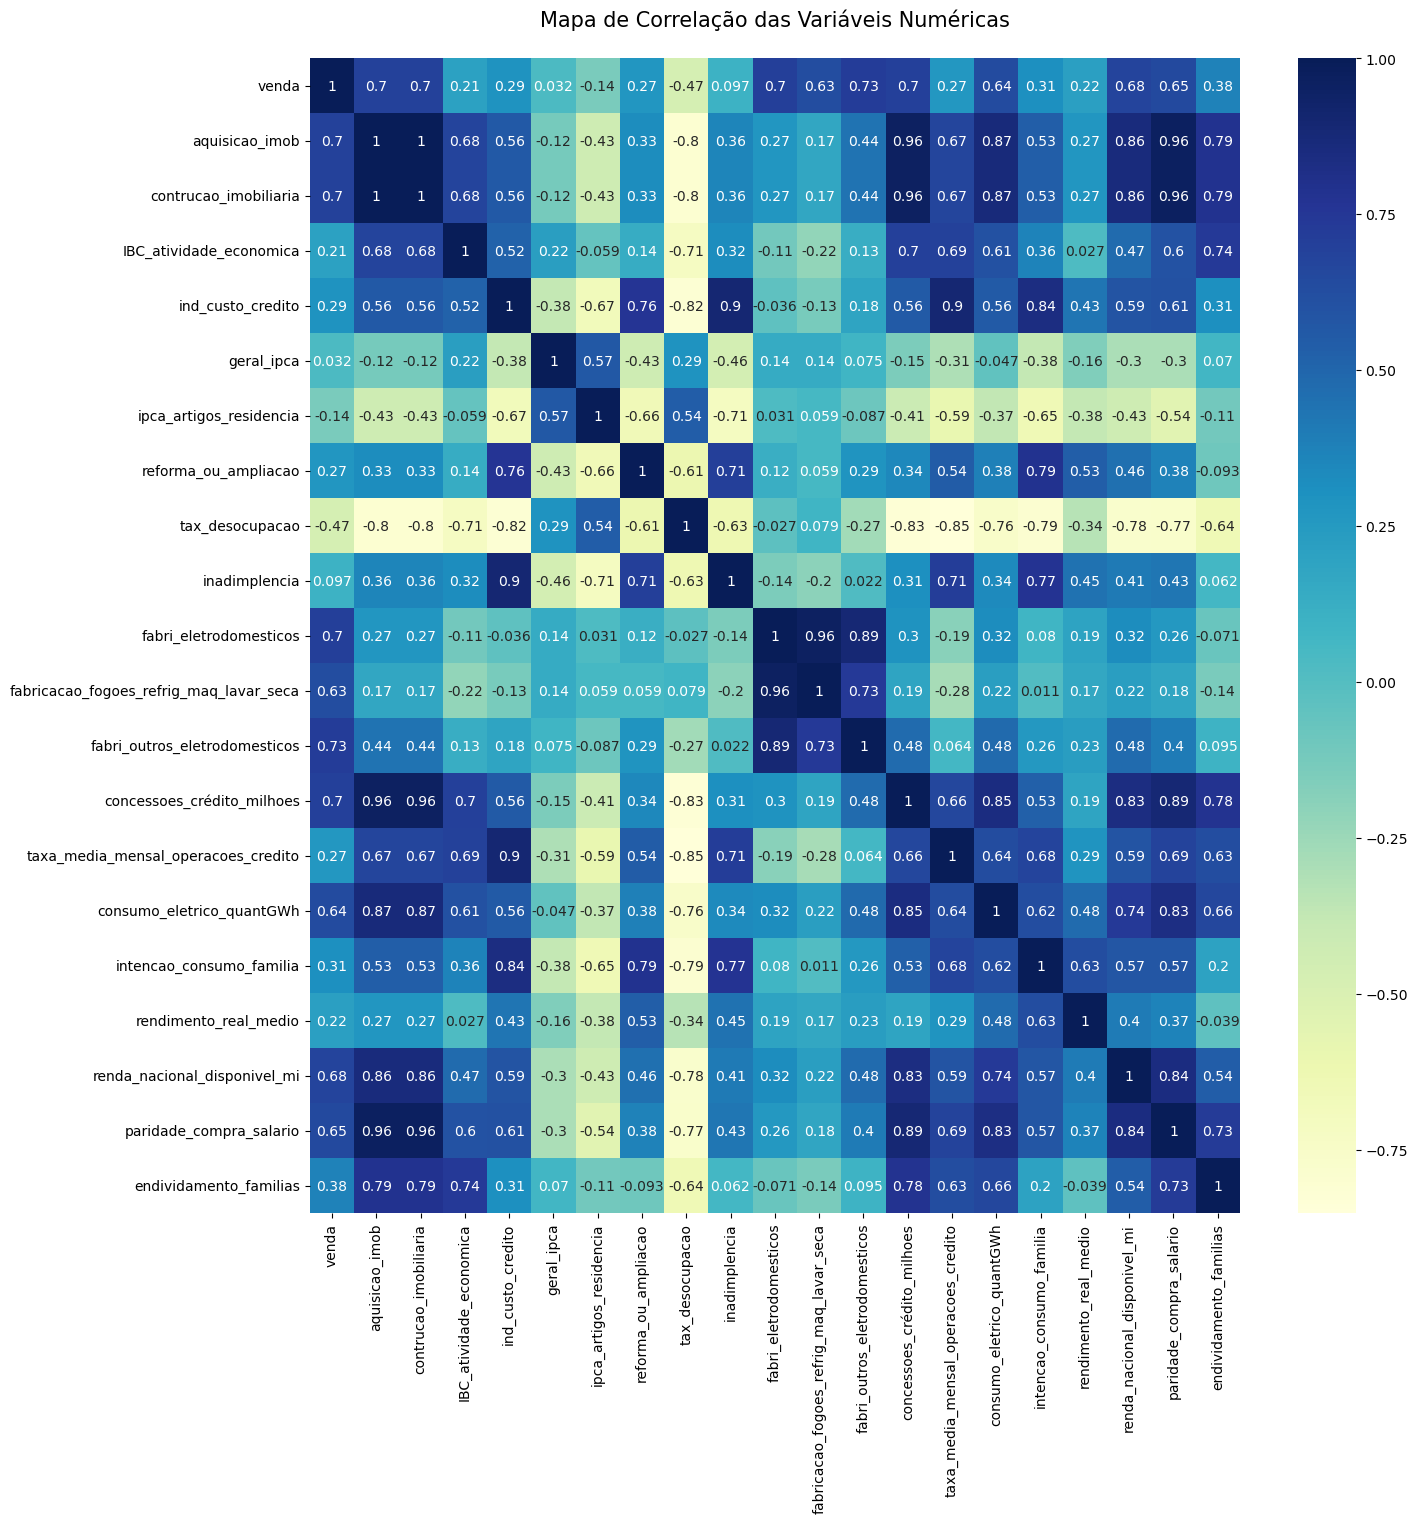

In [25]:
# Heatmap
plt.figure(figsize = (15, 15))
sns.heatmap(df_m.corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

In [48]:
df_m.reset_index()

,periodo,venda,aquisicao_imob,contrucao_imobiliaria,IBC_atividade_economica,ind_custo_credito,geral_ipca,ipca_artigos_residencia,reforma_ou_ampliacao,tax_desocupacao,inadimplencia,fabri_eletrodomesticos,fabricacao_fogoes_refrig_maq_lavar_seca,fabri_outros_eletrodomesticos,concessoes_crédito_milhoes,taxa_media_mensal_operacoes_credito,consumo_eletrico_quantGWh,intencao_consumo_familia,rendimento_real_medio,renda_nacional_disponivel_mi,paridade_compra_salario,endividamento_familias
0,2018-01,74709.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.91510,255548.0,1.94,40071.0,83.592336,3572,628.320,428.525746,37.31
1,2018-02,101543.0,464.96,34.11,1.14,21.51,NaN,NaN,NaN,12.7,3.40,97.34621,94.85664,103.73398,244817.0,1.98,39207.0,87.114411,3602,606.490,429.695367,37.29
2,2018-03,103598.0,467.75,34.38,1.01,21.30,NaN,NaN,NaN,13.2,3.29,108.95466,108.15979,110.99415,281668.0,1.94,41139.0,88.034538,3498,573.586,430.366091,37.32
3,2018-04,142282.0,469.91,34.65,1.48,21.28,NaN,NaN,NaN,13.0,3.26,105.42978,105.16889,106.09916,280100.0,1.92,40721.0,86.906700,3218,566.931,431.171464,37.55
4,2018-05,73361.0,472.64,34.91,1.11,21.00,NaN,NaN,NaN,12.8,3.28,87.31913,88.46248,84.38552,283288.0,1.85,39315.0,87.070197,3207,564.932,431.111277,37.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2025-04,210805.0,1047.08,106.60,4.02,22.88,0.41,0.53,635.21,6.6,3.71,119.98046,107.70468,160.35663,644258.0,2.30,47025.0,101.361210,3502,732.141,597.323792,48.88
88,2025-05,222356.0,1054.28,107.64,4.16,22.96,0.32,-0.27,633.51,6.2,3.79,130.43912,118.19572,170.70880,648124.0,2.31,46671.0,100.811174,3487,743.920,596.483367,48.88
89,2025-06,231102.0,1058.99,108.75,3.97,23.13,0.31,0.08,634.00,5.8,3.83,109.40103,107.38828,116.02115,641402.0,2.33,45088.0,100.846143,3510,763.821,597.143227,48.81
90,2025-07,268248.0,1058.14,109.83,3.56,23.19,0.35,0.09,634.51,5.6,NaN,123.21631,115.37294,149.01387,646057.0,2.31,45303.0,101.394838,3518,789.165,596.791764,48.57


venda                                      1.000000
fabri_outros_eletrodomesticos              0.735116
renda_nacional_disponivel_mi               0.712461
fabri_eletrodomesticos                     0.705193
concessoes_crédito_milhoes                 0.698238
contrucao_imobiliaria                      0.685537
aquisicao_imob                             0.677391
paridade_compra_salario                    0.659809
consumo_eletrico_quantGWh                  0.650662
fabricacao_fogoes_refrig_maq_lavar_seca    0.635007
endividamento_familias                     0.462317
reforma_ou_ampliacao                       0.301679
taxa_media_mensal_operacoes_credito        0.258841
intencao_consumo_familia                   0.254659
rendimento_real_medio                      0.203791
ind_custo_credito                          0.178927
IBC_atividade_economica                    0.107266
inadimplencia                              0.063897
geral_ipca                                 0.060481
ipca_artigos

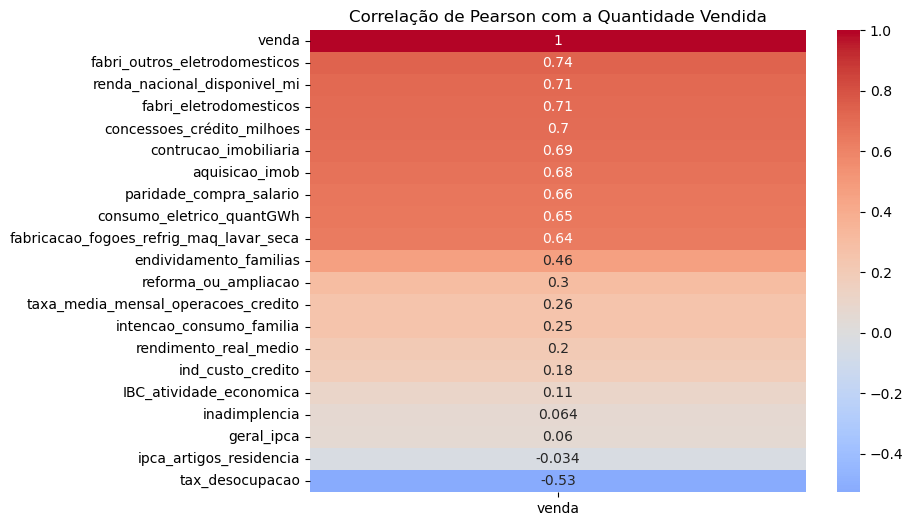

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar apenas colunas numéricas
corr = df_m.select_dtypes(include=['float64', 'int64']).corr()

# Correlação com a variável de vendas
corr_vendas = corr['venda'].sort_values(ascending=False)

# Exibir tabela
print(corr_vendas)

# Visualizar em gráfico
plt.figure(figsize=(8,6))
sns.heatmap(corr[['venda']].sort_values(by='venda', ascending=False), annot=True, cmap='coolwarm', center=0)
plt.title('Correlação de Pearson com a Quantidade Vendida')
plt.show()

In [77]:
corr_vendas[corr_vendas > .60].index.to_list()

['venda',
 'fabri_outros_eletrodomesticos',
 'renda_nacional_disponivel_mi',
 'fabri_eletrodomesticos',
 'concessoes_crédito_milhoes',
 'contrucao_imobiliaria',
 'aquisicao_imob',
 'paridade_compra_salario',
 'consumo_eletrico_quantGWh',
 'fabricacao_fogoes_refrig_maq_lavar_seca']

In [82]:
# Preencher valores missing com interpolação para análise temporal
df_m = df_m.interpolate(method='linear')

# Selecionar variáveis mais relevantes baseado na correlação
variaveis_analise = corr_vendas[corr_vendas > .60].index.to_list()

df_m_analysis = df_m[variaveis_analise].dropna()

print("Dimensões do dataset para análise:", df_m_analysis.shape)
print("\nPrimeiras linhas:")
print(df_m_analysis.head())

Dimensões do dataset para análise: (92, 10)

Primeiras linhas:
            venda  ...  fabricacao_fogoes_refrig_maq_lavar_seca
periodo            ...                                         
2018-01   74709.0  ...                                100.99201
2018-02  101543.0  ...                                 94.85664
2018-03  103598.0  ...                                108.15979
2018-04  142282.0  ...                                105.16889
2018-05   73361.0  ...                                 88.46248

[5 rows x 10 columns]


In [80]:
from statsmodels.tsa.stattools import grangercausalitytests

# Teste de Causalidade de Granger
print("=== TESTE DE CAUSALIDADE DE GRANGER ===\n")
print("H0: A variável X NÃO causa Granger a variável Y")
print("Significância: p < 0.05 indica causalidade\n")

# Configuração
max_lag = 4  # testar até 4 meses de defasagem

# Testar cada variável como potencial causa das vendas
for variavel in variaveis_analise[1:]:  # excluir 'venda'
    print(f"\n--- {variavel} → VENDA ---")
    
    # Preparar dados para o teste
    test_data = df_m_analysis[['venda', variavel]].dropna()
    
    try:
        # Executar teste de Granger
        resultado = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
        
        # Coletar p-values para cada lag
        p_values = []
        for lag in range(1, max_lag + 1):
            p_value = resultado[lag][0]['ssr_ftest'][1]
            p_values.append(p_value)
            print(f"Lag {lag}: p-value = {p_value:.4f} {'***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.1 else ''}")
        
        # Verificar se há causalidade em algum lag
        causal = any(p < 0.1 for p in p_values)
        print(f"Conclusão: {'HÁ evidências de causalidade' if causal else 'NÃO há evidências de causalidade'}")
        
    except Exception as e:
        print(f"Erro no teste: {e}")

=== TESTE DE CAUSALIDADE DE GRANGER ===

H0: A variável X NÃO causa Granger a variável Y
Significância: p < 0.05 indica causalidade


--- fabri_outros_eletrodomesticos → VENDA ---
Lag 1: p-value = 0.5143 
Lag 2: p-value = 0.8594 
Lag 3: p-value = 0.9044 
Lag 4: p-value = 0.2444 
Conclusão: NÃO há evidências de causalidade

--- renda_nacional_disponivel_mi → VENDA ---
Lag 1: p-value = 0.0006 ***
Lag 2: p-value = 0.0229 **
Lag 3: p-value = 0.0504 *
Lag 4: p-value = 0.1094 
Conclusão: HÁ evidências de causalidade

--- fabri_eletrodomesticos → VENDA ---
Lag 1: p-value = 0.6646 
Lag 2: p-value = 0.3558 
Lag 3: p-value = 0.5052 
Lag 4: p-value = 0.3094 
Conclusão: NÃO há evidências de causalidade

--- concessoes_crédito_milhoes → VENDA ---
Lag 1: p-value = 0.0182 **
Lag 2: p-value = 0.0089 ***
Lag 3: p-value = 0.0242 **
Lag 4: p-value = 0.0582 *
Conclusão: HÁ evidências de causalidade

--- contrucao_imobiliaria → VENDA ---
Lag 1: p-value = 0.0005 ***
Lag 2: p-value = 0.0220 **
Lag 3: p-val

C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions shou

In [87]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

def analisar_lags_ccf(variavel_alvo, variavel_predictora, dados, max_lag=12):
    """
    Analisa correlações cruzadas para encontrar lags ideais
    """
    # Calcular correlação cruzada
    correlacoes = ccf(dados[variavel_alvo], dados[variavel_predictora])
    
    # Pegar apenas os lags positivos (predictora afetando alvo)
    correlacoes_lags = correlacoes[:max_lag+1]
    
    # Encontrar lags com maior correlação
    lags_importantes = []
    for lag, corr in enumerate(correlacoes_lags):
        if abs(corr) > 0.3:  # threshold de correlação
            lags_importantes.append((lag, corr))
    
    # Ordenar por magnitude da correlação
    lags_importantes.sort(key=lambda x: abs(x[1]), reverse=True)
    
    return lags_importantes, correlacoes_lags

# Exemplo para aquisição imobiliária
lags_aquisicao, corrs_aquisicao = analisar_lags_ccf('venda', 'aquisicao_imob', df_m_analysis)
print("Lags importantes para aquisição imobiliária:")
for lag, corr in lags_aquisicao[:5]:
    print(f"  Lag {lag}: correlação = {corr:.4f}")

Lags importantes para aquisição imobiliária:
  Lag 0: correlação = 0.6893
  Lag 1: correlação = 0.6606
  Lag 2: correlação = 0.6394
  Lag 3: correlação = 0.6176
  Lag 4: correlação = 0.6069


In [88]:
def encontrar_lag_otimo_granger(variavel_x, variavel_y, dados, max_lag=8):
    """
    Encontra o lag ótimo usando teste de Granger
    """
    test_data = dados[[variavel_y, variavel_x]].dropna()
    
    melhor_lag = None
    menor_p_value = 1.0
    
    for lag in range(1, max_lag + 1):
        try:
            resultado = grangercausalitytests(test_data, maxlag=lag, verbose=False)
            p_value = resultado[lag][0]['ssr_ftest'][1]
            
            if p_value < menor_p_value:
                menor_p_value = p_value
                melhor_lag = lag
                
        except Exception as e:
            continue
    
    return melhor_lag, menor_p_value

# Testar para cada variável
print("Lags ótimos pelo teste de Granger:")
for variavel in variaveis_analise[1:]:
    lag_otimo, p_value = encontrar_lag_otimo_granger(variavel, 'venda', df_m_analysis)
    if lag_otimo:
        print(f"  {variavel}: Lag {lag_otimo} (p-value: {p_value:.4f})")

Lags ótimos pelo teste de Granger:
  fabri_outros_eletrodomesticos: Lag 4 (p-value: 0.2444)
  renda_nacional_disponivel_mi: Lag 1 (p-value: 0.0006)
  fabri_eletrodomesticos: Lag 4 (p-value: 0.3094)


C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  concessoes_crédito_milhoes: Lag 2 (p-value: 0.0089)
  contrucao_imobiliaria: Lag 1 (p-value: 0.0005)
  aquisicao_imob: Lag 1 (p-value: 0.0011)
  paridade_compra_salario: Lag 1 (p-value: 0.0002)


C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  consumo_eletrico_quantGWh: Lag 7 (p-value: 0.0023)
  fabricacao_fogoes_refrig_maq_lavar_seca: Lag 2 (p-value: 0.2463)


C:\Users\marce\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [94]:
from statsmodels.tsa.vector_ar.var_model import VAR

def encontrar_lag_var(dados, max_lag=7):
    """
    Encontra lag ótimo usando critérios de informação
    """
    modelo = VAR(dados)
    resultados = modelo.select_order(max_lag)
    
    print("Critérios de informação para diferentes lags:")
    print(f"AIC: {resultados.aic}")
    print(f"BIC: {resultados.bic}")
    print(f"HQIC: {resultados.hqic}")
    
    # Retornar lag com menor AIC (mais comum)
    return resultados.aic

# Encontrar lag ótimo para o sistema multivariado
lag_aic = encontrar_lag_var(df_m_analysis[variaveis_analise])
print(f"Lag ótimo pelo AIC: {lag_aic}")

Critérios de informação para diferentes lags:
AIC: 7
BIC: 1
HQIC: 7
Lag ótimo pelo AIC: 7


In [97]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def selecao_lags_stepwise(variavel_alvo, variaveis_predictoras, dados, max_lags=4):
    """
    Seleção stepwise de lags usando Recursive Feature Elimination
    """
    # Criar dataset com múltiplos lags
    X_total = []
    nomes_features = []
    y = []
    
    for i in range(max_lags, len(dados)):
        # Target
        y.append(dados[variavel_alvo].iloc[i])
        
        # Features com múltiplos lags
        features_row = []
        for var in variaveis_predictoras:
            for lag in range(1, max_lags + 1):
                features_row.append(dados[var].iloc[i - lag])
                if i == max_lags:  # só uma vez para criar nomes
                    nomes_features.append(f"{var}_lag{lag}")
        
        X_total.append(features_row)
    
    X_total = np.array(X_total)
    y = np.array(y)
    
    # Seleção RFE
    modelo = LinearRegression()
    selector = RFE(modelo, n_features_to_select=10, step=1)  # selecionar top 10 features
    selector = selector.fit(X_total, y)
    
    # Features selecionadas
    features_selecionadas = []
    for i, selecionada in enumerate(selector.support_):
        if selecionada:
            features_selecionadas.append(nomes_features[i])
    
    return features_selecionadas, selector

# Executar seleção stepwise
variaveis_predictoras = variaveis_analise
features_selecionadas, selector = selecao_lags_stepwise('venda', variaveis_predictoras, df_m_analysis)

print("Features selecionadas pelo RFE:")
for feature in features_selecionadas:
    print(f"  • {feature}")

Features selecionadas pelo RFE:
  • fabri_outros_eletrodomesticos_lag1
  • fabri_outros_eletrodomesticos_lag4
  • fabri_eletrodomesticos_lag1
  • fabri_eletrodomesticos_lag4
  • contrucao_imobiliaria_lag2
  • contrucao_imobiliaria_lag3
  • contrucao_imobiliaria_lag4
  • aquisicao_imob_lag4
  • fabricacao_fogoes_refrig_maq_lavar_seca_lag1
  • fabricacao_fogoes_refrig_maq_lavar_seca_lag4


In [104]:
def plot_analise_lags_completa(variavel_alvo, variavel_predictora, dados, max_lag=8):
    """
    Análise visual completa de lags
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Correlação Cruzada
    correlacoes = ccf(dados[variavel_alvo], dados[variavel_predictora])[:max_lag+1]
    axes[0,0].bar(range(max_lag+1), correlacoes)
    axes[0,0].set_title(f'Correlação Cruzada: {variavel_predictora} → {variavel_alvo}')
    axes[0,0].set_xlabel('Lag')
    axes[0,0].set_ylabel('Correlação')
    
    # 2. Série Temporal com diferentes lags
    axes[0,1].plot(dados[variavel_alvo], label=variavel_alvo, alpha=0.7)
    for lag in [1, 3, 6]:
        axes[0,1].plot(dados[variavel_predictora].shift(lag), 
                      label=f'{variavel_predictora} (lag {lag})', alpha=0.7)
    axes[0,1].set_title('Séries Temporais com Diferentes Lags')
    axes[0,1].legend()
    
    # 3. Scatter plots com lags selecionados
    lags_analisar = [1, 3, 6]
    for idx, lag in enumerate(lags_analisar):
        row = 1
        col = idx
        axes[row, col].scatter(dados[variavel_predictora].shift(lag), 
                              dados[variavel_alvo], alpha=0.5)
        axes[row, col].set_title(f'Lag {lag}')
        axes[row, col].set_xlabel(variavel_predictora)
        if col == 0:
            axes[row, col].set_ylabel(variavel_alvo)
    
    plt.tight_layout()
    plt.show()

# Gerar análise visual para variáveis importantes
for var in variaveis_analise[1:]:
    plot_analise_lags_completa('venda', var, df_m_analysis)

TypeError: float() argument must be a string or a real number, not 'Period'

In [105]:
df_m_analysis

,venda,fabri_outros_eletrodomesticos,renda_nacional_disponivel_mi,fabri_eletrodomesticos,concessoes_crédito_milhoes,contrucao_imobiliaria,aquisicao_imob,paridade_compra_salario,consumo_eletrico_quantGWh,fabricacao_fogoes_refrig_maq_lavar_seca
periodo,,,,,,,,,,
2018-01,74709.0,98.91510,628.320,100.40956,255548.0,33.71,461.42,428.525746,40071.0,100.99201
2018-02,101543.0,103.73398,606.490,97.34621,244817.0,34.11,464.96,429.695367,39207.0,94.85664
2018-03,103598.0,110.99415,573.586,108.95466,281668.0,34.38,467.75,430.366091,41139.0,108.15979
2018-04,142282.0,106.09916,566.931,105.42978,280100.0,34.65,469.91,431.171464,40721.0,105.16889
2018-05,73361.0,84.38552,564.932,87.31913,283288.0,34.91,472.64,431.111277,39315.0,88.46248
...,...,...,...,...,...,...,...,...,...,...
2025-04,210805.0,160.35663,732.141,119.98046,644258.0,106.60,1047.08,597.323792,47025.0,107.70468
2025-05,222356.0,170.70880,743.920,130.43912,648124.0,107.64,1054.28,596.483367,46671.0,118.19572
2025-06,231102.0,116.02115,763.821,109.40103,641402.0,108.75,1058.99,597.143227,45088.0,107.38828
